Saving Unknown.jpeg to Unknown (3).jpeg


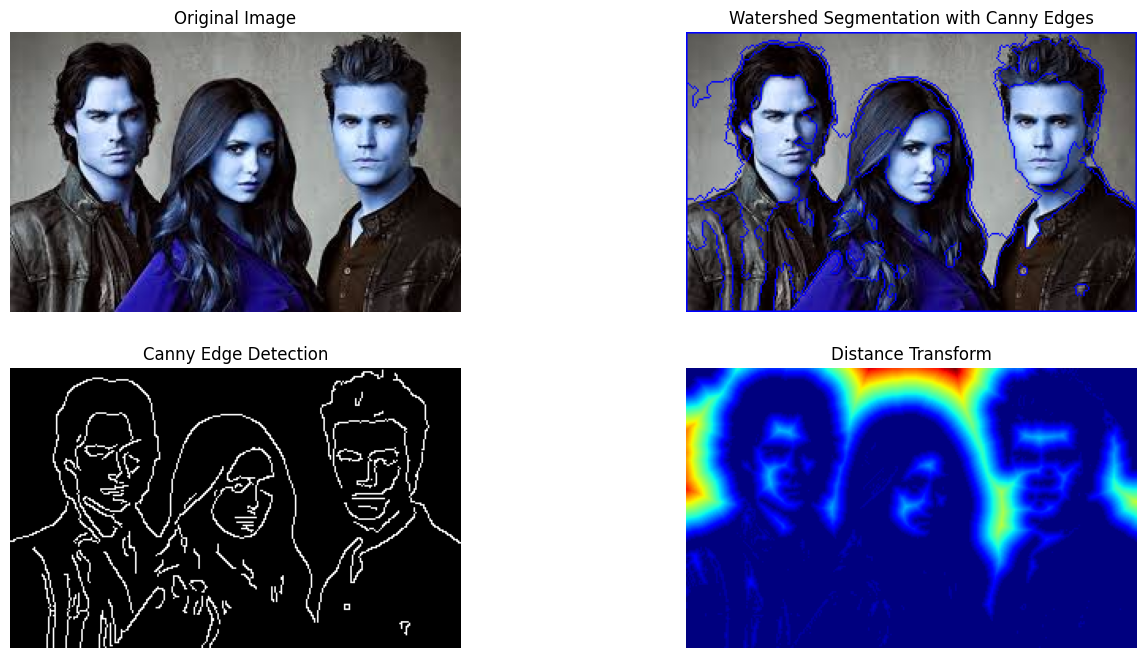

In [ ]:
# Install necessary libraries (if not already installed)
!pip install opencv-python scikit-image matplotlib numpy

import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
from PIL import Image

# Upload an image file
uploaded = files.upload()

# Open the uploaded image (assuming the first uploaded file)
image_path = list(uploaded.keys())[0]
image = Image.open(image_path)

# Resize large images while maintaining aspect ratio
max_width = 800  # Resize if width > 800 pixels
if image.width > max_width:
    aspect_ratio = image.height / image.width
    new_height = int(max_width * aspect_ratio)
    image = image.resize((max_width, new_height), Image.LANCZOS)

# Convert to numpy array
image_gray = np.array(image.convert('L'))  # Grayscale
image_color = np.array(image)  # Original color image

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)

# Perform edge detection (Canny)
edges = cv2.Canny(blurred, 100, 200)

# Create a binary image using Otsu's thresholding
_, binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Perform morphological operations to refine edges
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(binary, kernel, iterations=3)  # Dilate background

# Distance Transform to find foreground objects
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find unknown region (possible boundaries)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Label markers for Watershed using Canny edges
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  # Ensure background is labeled as 1
markers[unknown == 255] = 0  # Mark unknown regions as 0

# Use Canny edges to refine markers
markers[edges > 0] = 255  # Mark Canny edges as strong edges

# Apply Watershed algorithm
cv2.watershed(image_color, markers)
image_color[markers == -1] = [255, 0, 0]  # Mark watershed boundaries in red

# Show the results using matplotlib
plt.figure(figsize=(16, 8))

# Display Original Image
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Display Segmented Image using Watershed
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.title("Watershed Segmentation with Canny Edges")
plt.axis('off')

# Display Canny Edge Detection result
plt.subplot(2, 2, 3)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

# Display Distance Transform
plt.subplot(2, 2, 4)
plt.imshow(dist_transform, cmap='jet')
plt.title("Distance Transform")
plt.axis('off')

# Show all images
plt.show()
